In [1]:
import librosa
import numpy as np
import pandas as pd
from scipy import signal
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pandas as pd
from pydub import AudioSegment
from musthe import *
import itertools


from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [2]:
def get_filename_components(input_string):
    components = namedtuple('Components', ['uma', 'db', 'chord', 'style', 'dynamic'])
    components_values = input_string.split('/')[-1].split('-')
    components.uma = components_values[0]
    components.db = components_values[1]
    components.chord = components_values[2]
    components.style = components_values[3]
    components.dynamic = components_values[4]

    return(components)

from string import digits

def get_chords(base_note):
    '''
    Returns all relevant chords of an input base note
    '''
    
    transforms = ['maj',
                  'min',
                  'aug',
                  'dim',
                  'dom7',
                  'min7',
                  'maj7',
                  'aug7',
                  'dim7',
                  'm7dim5',
                  'sus2',
                  'sus4',
                  'open5']
    
    transform_notes = {}
    transform_notes_base = {}
    for transform in transforms:
        chord = Chord(Note(base_note), transform)
        transform_notes[f"{transform}"] = chord.notes
        
        remove_digits = str.maketrans('', '', digits)        
        transform_notes_base[f"{base_note}_{transform}"] = [str(note.note).translate(remove_digits) for note in chord.notes]
  
    out = {'chords': transform_notes,
           'chords_base': transform_notes_base}
    return(out)

# def get_chord_notes(chord):
#     '''
#     chord (str): "C1C2C3"
#     returns (list): [note, note, note]
#     '''
    
#     notes = [char for char in chord if char.isupper()]
    
#     return(notes)


def get_chord_notes(chord):
    '''
    Takes as input a list of Note() and will return a list of strings
    
    returns:
        list[str]
    '''
    
    notes = [note.note for note in chord]
    
    return notes
    
    
def import_sounds(duration=1000, *args):
    '''
    duration: suration of input in milliseconds.  1000 ms = 1 second
    '''
    sounds = []
    for sound_file in args:
        sounds.append(AudioSegment.from_file(sound_file)[:duration])
        
    return sounds


def combine_notes(*args):
    combined = args[0]
    for sound in args[1:]:
    
        combined = combined.overlay(sound)

    return combined


def to_set(x):
    return set(x)

In [3]:
import os
from shutil import copyfile
from collections import namedtuple
from tqdm import tqdm_notebook as tqdm
from glob import glob

# Combine single notes to create a chord

## Import labels of dataset:

In [7]:
labels = pd.read_json("data/nsynth-train//examples.json")
labels = labels.T.reset_index()
labels.rename(columns={'index': 'filename'}, inplace=True)
labels.head()

,filename,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,qualities,qualities_str,sample_rate,velocity
0,guitar_acoustic_001-082-050,39,3,guitar,0,acoustic,guitar_acoustic_001,16629,guitar_acoustic_001-082-050,82,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[percussive],16000,50
1,bass_synthetic_120-108-050,881,0,bass,2,synthetic,bass_synthetic_120,168243,bass_synthetic_120-108-050,108,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[percussive],16000,50
2,organ_electronic_120-050-127,979,6,organ,1,electronic,organ_electronic_120,88495,organ_electronic_120-050-127,50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],16000,127
3,guitar_electronic_021-026-025,346,3,guitar,1,electronic,guitar_electronic_021,146382,guitar_electronic_021-026-025,26,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]","[fast_decay, percussive]",16000,25
4,organ_electronic_011-079-075,188,6,organ,1,electronic,organ_electronic_011,244275,organ_electronic_011-079-075,79,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[bright],16000,75


In [8]:
qualities = pd.DataFrame(list(labels.qualities), columns=['bright',
                                                          'dark',
                                                          'distortion',
                                                          'fast_decay',
                                                          'long_release',
                                                          'multiphonic',
                                                          'nonlinear_env',
                                                          'percussive',
                                                          'reverb',
                                                          'tempo-synced'])

labels = pd.concat([labels, qualities], axis=1)
labels.drop(['qualities', 'qualities_str'], axis=1, inplace=True)

In [9]:
# Show the notes in the dataset
pitch_unique = labels.pitch.unique()
pitch_unique.sort()
pitch_unique

array([9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120],
      dtype=object)

In [10]:
labels.velocity.value_counts()

127    61197
100    57068
50     57030
75     57028
25     56882
Name: velocity, dtype: int64

In [11]:
# Assign note letter to pitch values
notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [12]:
# Create dictionary of pitch: note letter
pitch_mapping = {}
pitch_mapping_specific_note = {}
note_index = 0
loop_counter = 0
# Iterate through all pitches
for i in range(0, 121):
    pitch_mapping[i] = notes[note_index]
    
    pitch_mapping_specific_note[i] = f"{notes[note_index]}{loop_counter}"
    
    note_index += 1
    if note_index >= 12:
        note_index = 0
        loop_counter += 1
    

In [13]:
pitch_mapping

{0: 'C',
 1: 'C#',
 2: 'D',
 3: 'D#',
 4: 'E',
 5: 'F',
 6: 'F#',
 7: 'G',
 8: 'G#',
 9: 'A',
 10: 'A#',
 11: 'B',
 12: 'C',
 13: 'C#',
 14: 'D',
 15: 'D#',
 16: 'E',
 17: 'F',
 18: 'F#',
 19: 'G',
 20: 'G#',
 21: 'A',
 22: 'A#',
 23: 'B',
 24: 'C',
 25: 'C#',
 26: 'D',
 27: 'D#',
 28: 'E',
 29: 'F',
 30: 'F#',
 31: 'G',
 32: 'G#',
 33: 'A',
 34: 'A#',
 35: 'B',
 36: 'C',
 37: 'C#',
 38: 'D',
 39: 'D#',
 40: 'E',
 41: 'F',
 42: 'F#',
 43: 'G',
 44: 'G#',
 45: 'A',
 46: 'A#',
 47: 'B',
 48: 'C',
 49: 'C#',
 50: 'D',
 51: 'D#',
 52: 'E',
 53: 'F',
 54: 'F#',
 55: 'G',
 56: 'G#',
 57: 'A',
 58: 'A#',
 59: 'B',
 60: 'C',
 61: 'C#',
 62: 'D',
 63: 'D#',
 64: 'E',
 65: 'F',
 66: 'F#',
 67: 'G',
 68: 'G#',
 69: 'A',
 70: 'A#',
 71: 'B',
 72: 'C',
 73: 'C#',
 74: 'D',
 75: 'D#',
 76: 'E',
 77: 'F',
 78: 'F#',
 79: 'G',
 80: 'G#',
 81: 'A',
 82: 'A#',
 83: 'B',
 84: 'C',
 85: 'C#',
 86: 'D',
 87: 'D#',
 88: 'E',
 89: 'F',
 90: 'F#',
 91: 'G',
 92: 'G#',
 93: 'A',
 94: 'A#',
 95: 'B',
 96: 'C',


In [14]:
pitch_mapping_specific_note

{0: 'C0',
 1: 'C#0',
 2: 'D0',
 3: 'D#0',
 4: 'E0',
 5: 'F0',
 6: 'F#0',
 7: 'G0',
 8: 'G#0',
 9: 'A0',
 10: 'A#0',
 11: 'B0',
 12: 'C1',
 13: 'C#1',
 14: 'D1',
 15: 'D#1',
 16: 'E1',
 17: 'F1',
 18: 'F#1',
 19: 'G1',
 20: 'G#1',
 21: 'A1',
 22: 'A#1',
 23: 'B1',
 24: 'C2',
 25: 'C#2',
 26: 'D2',
 27: 'D#2',
 28: 'E2',
 29: 'F2',
 30: 'F#2',
 31: 'G2',
 32: 'G#2',
 33: 'A2',
 34: 'A#2',
 35: 'B2',
 36: 'C3',
 37: 'C#3',
 38: 'D3',
 39: 'D#3',
 40: 'E3',
 41: 'F3',
 42: 'F#3',
 43: 'G3',
 44: 'G#3',
 45: 'A3',
 46: 'A#3',
 47: 'B3',
 48: 'C4',
 49: 'C#4',
 50: 'D4',
 51: 'D#4',
 52: 'E4',
 53: 'F4',
 54: 'F#4',
 55: 'G4',
 56: 'G#4',
 57: 'A4',
 58: 'A#4',
 59: 'B4',
 60: 'C5',
 61: 'C#5',
 62: 'D5',
 63: 'D#5',
 64: 'E5',
 65: 'F5',
 66: 'F#5',
 67: 'G5',
 68: 'G#5',
 69: 'A5',
 70: 'A#5',
 71: 'B5',
 72: 'C6',
 73: 'C#6',
 74: 'D6',
 75: 'D#6',
 76: 'E6',
 77: 'F6',
 78: 'F#6',
 79: 'G6',
 80: 'G#6',
 81: 'A6',
 82: 'A#6',
 83: 'B6',
 84: 'C7',
 85: 'C#7',
 86: 'D7',
 87: 'D#7',
 88: 

In [15]:
# Add letter value to labels dataset
labels['note'] = labels.pitch.map(pitch_mapping)
labels['note_specific'] = labels.pitch.map(pitch_mapping_specific_note)
labels.head()

,filename,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,...,dark,distortion,fast_decay,long_release,multiphonic,nonlinear_env,percussive,reverb,tempo-synced,note_specific
0,guitar_acoustic_001-082-050,39,3,guitar,0,acoustic,guitar_acoustic_001,A#,guitar_acoustic_001-082-050,82,...,0,0,0,0,0,0,1,0,0,A#6
1,bass_synthetic_120-108-050,881,0,bass,2,synthetic,bass_synthetic_120,C,bass_synthetic_120-108-050,108,...,0,0,0,0,0,0,1,0,0,C9
2,organ_electronic_120-050-127,979,6,organ,1,electronic,organ_electronic_120,D,organ_electronic_120-050-127,50,...,0,0,0,0,0,0,0,0,0,D4
3,guitar_electronic_021-026-025,346,3,guitar,1,electronic,guitar_electronic_021,D,guitar_electronic_021-026-025,26,...,0,0,1,0,0,0,1,0,0,D2
4,organ_electronic_011-079-075,188,6,organ,1,electronic,organ_electronic_011,G,organ_electronic_011-079-075,79,...,0,0,0,0,0,0,0,0,0,G6


In [16]:
labels[labels.note_specific == "A4"]

,filename,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,...,dark,distortion,fast_decay,long_release,multiphonic,nonlinear_env,percussive,reverb,tempo-synced,note_specific
31,bass_synthetic_077-057-127,692,0,bass,2,synthetic,bass_synthetic_077,A,bass_synthetic_077-057-127,57,...,0,0,0,0,0,0,0,0,0,A4
63,keyboard_electronic_080-057-075,843,4,keyboard,1,electronic,keyboard_electronic_080,A,keyboard_electronic_080-057-075,57,...,0,0,1,0,0,0,1,0,0,A4
71,string_acoustic_040-057-075,296,8,string,0,acoustic,string_acoustic_040,A,string_acoustic_040-057-075,57,...,0,0,0,0,0,0,0,1,0,A4
97,keyboard_electronic_035-057-025,501,4,keyboard,1,electronic,keyboard_electronic_035,A,keyboard_electronic_035-057-025,57,...,0,0,0,0,0,0,0,0,0,A4
225,brass_acoustic_044-057-050,401,1,brass,0,acoustic,brass_acoustic_044,A,brass_acoustic_044-057-050,57,...,0,0,1,0,0,0,0,1,0,A4
293,synth_lead_synthetic_000-057-075,223,9,synth_lead,2,synthetic,synth_lead_synthetic_000,A,synth_lead_synthetic_000-057-075,57,...,0,1,1,0,0,0,0,0,0,A4
337,mallet_acoustic_025-057-075,298,5,mallet,0,acoustic,mallet_acoustic_025,A,mallet_acoustic_025-057-075,57,...,0,0,0,0,0,0,0,0,0,A4
350,mallet_synthetic_003-057-100,396,5,mallet,2,synthetic,mallet_synthetic_003,A,mallet_synthetic_003-057-100,57,...,0,0,0,0,1,1,0,0,0,A4
539,flute_acoustic_003-057-075,132,2,flute,0,acoustic,flute_acoustic_003,A,flute_acoustic_003-057-075,57,...,0,0,0,0,0,0,0,0,0,A4
653,reed_acoustic_055-057-075,775,7,reed,0,acoustic,reed_acoustic_055,A,reed_acoustic_055-057-075,57,...,0,0,0,0,0,0,0,0,0,A4


We are going to use get_chords to generate all relevant chords and there notes.  Each note A0-A8...G0-G8 will be produced. 

Start with major / minor chords

In [17]:
notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
# selected_structures = ['maj', 'min']

selected_structures = ['maj',
                       'min',
                       'aug',
                       'dim',
                       'dom7',
                       'min7',
                       'maj7',
                       'aug7',
                       'dim7',
                       'm7dim5',
                       'sus2',
                       'sus4',
                       'open5']

In [18]:
all_chords = []
all_chords_meta = []
for note in notes:
    for i in range(1, 8 + 1):
        generated_chords = get_chords(f"{note}{i}")['chords']
        for structure in selected_structures:
            all_chords.append(generated_chords[structure])
            all_chords_meta.append((f"{note}{i}", structure))



In [19]:
all_chords

[[Note('C1'), Note('E1'), Note('G1')],
 [Note('C1'), Note('Eb1'), Note('G1')],
 [Note('C1'), Note('E1'), Note('G#1')],
 [Note('C1'), Note('Eb1'), Note('Gb1')],
 [Note('C1'), Note('E1'), Note('G1'), Note('Bb1')],
 [Note('C1'), Note('Eb1'), Note('G1'), Note('Bb1')],
 [Note('C1'), Note('E1'), Note('G1'), Note('B1')],
 [Note('C1'), Note('E1'), Note('G#1'), Note('Bb1')],
 [Note('C1'), Note('Eb1'), Note('Gb1'), Note('Bbb1')],
 [Note('C1'), Note('Eb1'), Note('Gb1'), Note('Bb1')],
 [Note('C1'), Note('G1'), Note('C2'), Note('D1')],
 [Note('C1'), Note('G1'), Note('C2'), Note('F1')],
 [Note('C1'), Note('G1'), Note('C2')],
 [Note('C2'), Note('E2'), Note('G2')],
 [Note('C2'), Note('Eb2'), Note('G2')],
 [Note('C2'), Note('E2'), Note('G#2')],
 [Note('C2'), Note('Eb2'), Note('Gb2')],
 [Note('C2'), Note('E2'), Note('G2'), Note('Bb2')],
 [Note('C2'), Note('Eb2'), Note('G2'), Note('Bb2')],
 [Note('C2'), Note('E2'), Note('G2'), Note('B2')],
 [Note('C2'), Note('E2'), Note('G#2'), Note('Bb2')],
 [Note('C2')

In [20]:
all_chords_meta

[('C1', 'maj'),
 ('C1', 'min'),
 ('C1', 'aug'),
 ('C1', 'dim'),
 ('C1', 'dom7'),
 ('C1', 'min7'),
 ('C1', 'maj7'),
 ('C1', 'aug7'),
 ('C1', 'dim7'),
 ('C1', 'm7dim5'),
 ('C1', 'sus2'),
 ('C1', 'sus4'),
 ('C1', 'open5'),
 ('C2', 'maj'),
 ('C2', 'min'),
 ('C2', 'aug'),
 ('C2', 'dim'),
 ('C2', 'dom7'),
 ('C2', 'min7'),
 ('C2', 'maj7'),
 ('C2', 'aug7'),
 ('C2', 'dim7'),
 ('C2', 'm7dim5'),
 ('C2', 'sus2'),
 ('C2', 'sus4'),
 ('C2', 'open5'),
 ('C3', 'maj'),
 ('C3', 'min'),
 ('C3', 'aug'),
 ('C3', 'dim'),
 ('C3', 'dom7'),
 ('C3', 'min7'),
 ('C3', 'maj7'),
 ('C3', 'aug7'),
 ('C3', 'dim7'),
 ('C3', 'm7dim5'),
 ('C3', 'sus2'),
 ('C3', 'sus4'),
 ('C3', 'open5'),
 ('C4', 'maj'),
 ('C4', 'min'),
 ('C4', 'aug'),
 ('C4', 'dim'),
 ('C4', 'dom7'),
 ('C4', 'min7'),
 ('C4', 'maj7'),
 ('C4', 'aug7'),
 ('C4', 'dim7'),
 ('C4', 'm7dim5'),
 ('C4', 'sus2'),
 ('C4', 'sus4'),
 ('C4', 'open5'),
 ('C5', 'maj'),
 ('C5', 'min'),
 ('C5', 'aug'),
 ('C5', 'dim'),
 ('C5', 'dom7'),
 ('C5', 'min7'),
 ('C5', 'maj7'),
 ('C5

Now that we have all the chords defined, let us try to import these files on disk and combine the audio samples

As a first pass, lets just import acoustic / keyboard notes.  We can broaden scope to other instruments later.

## Considerations

- Each note for the generated chords had to come from the same instrument type and family
- Each note for the generated chord must have the same effect/style applied to it

In [21]:
# labels.instrument_family_str.unique()
# labels.instrument_source_str.unique()
instrument_families = ['guitar', 'bass', 'keyboard', 'string']
instrument_source = ['acoustic']

## Iterate through all chords

In [25]:
labels.head()

,filename,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,...,dark,distortion,fast_decay,long_release,multiphonic,nonlinear_env,percussive,reverb,tempo-synced,note_specific
0,guitar_acoustic_001-082-050,39,3,guitar,0,acoustic,guitar_acoustic_001,A#,guitar_acoustic_001-082-050,82,...,0,0,0,0,0,0,1,0,0,A#6
1,bass_synthetic_120-108-050,881,0,bass,2,synthetic,bass_synthetic_120,C,bass_synthetic_120-108-050,108,...,0,0,0,0,0,0,1,0,0,C9
2,organ_electronic_120-050-127,979,6,organ,1,electronic,organ_electronic_120,D,organ_electronic_120-050-127,50,...,0,0,0,0,0,0,0,0,0,D4
3,guitar_electronic_021-026-025,346,3,guitar,1,electronic,guitar_electronic_021,D,guitar_electronic_021-026-025,26,...,0,0,1,0,0,0,1,0,0,D2
4,organ_electronic_011-079-075,188,6,organ,1,electronic,organ_electronic_011,G,organ_electronic_011-079-075,79,...,0,0,0,0,0,0,0,0,0,G6


In [26]:
generate_chord_notes

['C1', 'E1', 'G1']

In [35]:
labels_chord_generaton = labels[(labels.instrument_family_str.isin(instrument_families) & (labels.instrument_source_str.isin(instrument_source))).reset_index(drop=True)]

In [40]:
ls data/nsynth-train/

audio/                   generaged_chords_single/
examples.json            generated_chords/


In [80]:
filename_notes_dictionary={}
for note_seq, note_seq_meta in tqdm(zip(all_chords, all_chords_meta), total=len(all_chords)):
    generate_chord_notes = get_chord_notes(note_seq)
    
    keep_cols = ['filename',
             'instrument_str',
             'note_specific',
             'bright',
             'dark',
             'distortion',
             'fast_decay',
             'long_release',
             'multiphonic',
             'nonlinear_env',
             'percussive',
             'reverb',
             'tempo-synced']

    generate_chord_notes_labels = (labels_chord_generaton[(labels_chord_generaton.note_specific.isin(generate_chord_notes))]
                                     .sort_values(['instrument',
                                                   'instrument_source',
                                                   'note_specific',
                                                   'bright',
                                                   'dark',
                                                   'distortion',
                                                   'fast_decay',
                                                   'long_release',
                                                   'multiphonic',
                                                   'nonlinear_env',
                                                   'percussive',
                                                   'reverb',
                                                   'tempo-synced'])[keep_cols])
    
    note_counts_per_instrument = generate_chord_notes_labels.groupby(['instrument_str'])['note_specific'].nunique().reset_index()
    note_counts_per_instrument.columns = ["instrument_str", "note_specific_count"]
    note_counts_per_instrument = note_counts_per_instrument[note_counts_per_instrument.note_specific_count == len(generate_chord_notes)]

    # Filter to only instruments that have all the relevant notes represented at least once
    generate_chord_notes_labels = generate_chord_notes_labels[generate_chord_notes_labels.instrument_str.isin(note_counts_per_instrument.instrument_str)].reset_index()
    
    # Iterate through each instrument_str and generate a chord with the notes
    for note_group in generate_chord_notes_labels.instrument_str.unique():
                
        notes_filenames = generate_chord_notes_labels[generate_chord_notes_labels.instrument_str == note_group]

        # Generate sets of the filenames for all the files for each note
        df = notes_filenames.groupby('note_specific')['filename'].agg({'set': to_set})

        # Generate a cartesian produce of all combinations of the files
        for counter, filenames_tuple in enumerate(itertools.product(*df.set)):
            # Limit the number of the same chord that will be generated by an individual instrument to 5 notes
            if counter >= 1:
                continue
            notes_filenames = [f"data/nsynth-train/audio/{filename}.wav" for filename in filenames_tuple]
            # import notes (only first second)
            sounds = import_sounds(1000, *notes_filenames)

            generated_chord = combine_notes(*sounds)
            filename_notes_dictionary[f"{'_'.join(note_seq_meta)}_{note_group}_iter{counter}.wav"] = notes_filenames
            generated_chord.export(f"data/nsynth-train/generated_chords_single/{'_'.join(note_seq_meta)}_{note_group}_iter{counter}.wav", format='wav')
            

/Users/mattgraziano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


## Explore some generated chords and see if they are any good

In [44]:
from librosa.feature import melspectrogram

In [ ]:
chord = import_sounds()

In [ ]:
melspectrogram()

In [51]:
filename_notes_dictionary["A#1_dim_guitar_acoustic_003_iter0.wav"]

['data/nsynth-train/audio/guitar_acoustic_003-022-127.wav',
 'data/nsynth-train/audio/guitar_acoustic_003-025-050.wav',
 'data/nsynth-train/audio/guitar_acoustic_003-028-025.wav']

In [55]:
import IPython.display as ipd
ipd.Audio('data/nsynth-train/audio/guitar_acoustic_003-028-025.wav')

In [52]:
ipd.Audio("data/nsynth-train/generated_chords_single/A#1_dim_guitar_acoustic_003_iter0.wav")

In [59]:
# chords = import_sounds(1000, "data/nsynth-train/generated_chords_single/A#1_dim_guitar_acoustic_003_iter0.wav")

In [61]:
# notes_filenames = filename_notes_dictionary["A#1_dim_guitar_acoustic_003_iter0.wav"]
# sounds = import_sounds(1000, *notes_filenames)

# generated_chord = combine_notes(*sounds)

In [74]:
chord, sr = librosa.load("data/nsynth-train/generated_chords_single/A#1_dim_guitar_acoustic_003_iter0.wav", sr=None)

In [75]:
import matplotlib.pyplot as plt

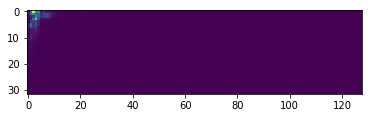

In [77]:
plt.imshow(melspectrogram(chord).T)